In [4]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings

In [7]:
# Docs to index
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# Add to vectorstore
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings,
)

retriever = vectorstore.as_retriever()

- BaseModel: This comes from the Pydantic library, which is commonly used for data validation and settings management in Python. It ensures that the data provided to the class adheres to the structure defined in the class. It validates and parses the data at runtime.

In [8]:
### Router
from typing import Literal
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

# Data model
#  This line defines a Python class named RouteQuery, which inherits from BaseModel.
class RouteQuery(BaseModel):

    # This is a docstring, which provides a description of the class.
    """Route a user query to the most relevant datasource."""

    # This line defines a class attribute called datasource. 
    # It specifies that datasource must take one of two string values: "vectorstore" or "wiki_search". 
    # This is done using the Literal type from Python’s typing module. 
    # The Field function is used to add additional validation and description to the class attribute.
    # The Field function ensures that this attribute is mandatory and provides a description for the model's purpose.

    datasource: Literal["vectorstore", "wiki_search"] = Field(
        ...,
        description="Given a user question choose to route it to wikipedia or a vectorstore.",
    )


OPENAI_API_KEY = "YOUR_OPENAI_API_KEY"
llm = ChatOpenAI(model="gpt-4-turbo-preview", temperature=0, api_key=OPENAI_API_KEY)

structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system = """You are an expert at routing a user question to a vectorstore or wikipedia.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use wiki-search."""

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router

print(
    question_router.invoke(
        {"question": "who is Sharukh Khan?"}
    )
)
print(question_router.invoke({"question": "What are the types of agent memory?"}))

c:\Python310\lib\site-packages\IPython\core\interactiveshell.py:3442: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


datasource='wiki_search'
datasource='vectorstore'


In [13]:
### Retrieval Grader
# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

structured_llm_grader = llm.with_structured_output(GradeDocuments)

retrieval_grader = grade_prompt | structured_llm_grader

question = "agent memory"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


In [14]:
### Generate
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")
print(prompt)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

c:\Python310\lib\site-packages\langsmith\client.py:323: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


input_variables=['context', 'question'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})]
In a LLM-powered autonomous agent system, memory is categorized into short-term and long-term types. Short-term memory involves in-context learning, utilizing the model's immediate context to learn and adapt. Long-term memory allows the agent to retain and recall information over extended periods, often th

In [15]:
### Hallucination Grader
# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""

hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

structured_llm_grader = llm.with_structured_output(GradeHallucinations)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

In [16]:
### Answer Grader
# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

structured_llm_grader = llm.with_structured_output(GradeAnswer)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

In [17]:
# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human","Here is the initial question: \n\n {question} \n Formulate only one improved question.",)
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

"How does an agent's memory function?"

In [20]:
### Working With Tools
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper

## Arxiv and wikipedia Tools
arxiv = ArxivAPIWrapper(top_K_results=1, doc_content_chars_max=200)

wiki = WikipediaAPIWrapper(top_K_results=1, doc_content_chars_max=200)

In [21]:
## Graph
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [24]:
wiki.run("What is machine learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and gen'

In [30]:
from langchain.schema import Document

def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}

def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

def wiki_search(state):
    """
    wiki search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---wikipedia---")
    print("---HELLO--")
    question = state["question"]
    print(question)

    # Wiki search
    docs = wiki.run(question)
    #print(docs["summary"])
    wiki_results = docs
    wiki_results = Document(page_content=wiki_results)

    return {"documents": wiki_results, "question": question}


### Edges ###
def route_question(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "wiki_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

In [31]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("wiki_search", wiki_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search": "wiki_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("wiki_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

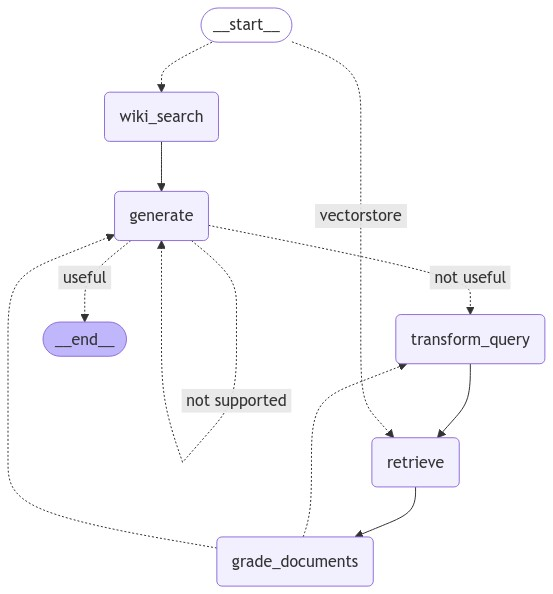

In [32]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [33]:
app

In [34]:
from pprint import pprint

# Run
inputs = {
    "question": "Tell me about Sharukh Khan?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO Wiki SEARCH---
---wikipedia---
---HELLO--
Tell me about Sharukh Khan?
"Node 'wiki_search':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('Shah Rukh Khan, often referred to by the initialism SRK, is an Indian actor '
 'and film producer known for his work in Hindi cinema. He was born on 2 '
 'November 1965. SRK is one of the most prominent figures in the Indian film '
 'industry.')


In [36]:
# Run
inputs = {"question": "What are the types of agent memory?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('The types of agent memory, as described, include sensory memory, short-term '
 '(or working) memory, and long-term memory. Long-term memory is further '
 'divided into explicit (or declarative) memory, which includes episodic and '
 'semantic memory, and implicit (or procedural) memory, which involves skills '
 'and routines performed automatically. These categories mirror the '
 'organization of human memory, encompassing the processes of